In [1]:
DEBUG = False

In [2]:
import os
import gc
import cv2
import time
import timm
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import albumentations
from pylab import rcParams
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.cuda.amp as amp
from torch.utils.data import  Dataset
import torch.nn.functional as F

%matplotlib inline
rcParams['figure.figsize'] = 20, 8
device = torch.device('cuda')
torch.backends.cudnn.benchmark = True

# Config

In [3]:
kernel_type = '0920_1bonev2_effv2s_224_15_6ch_augv2_mixupp5_drl3_rov1p2_bs8_lr23e5_eta23e6_50ep'
load_kernel = None
load_last = True

n_folds = 5
#backbone = 'tf_efficientnetv2_s.in21k_ft_in1k'
#backbone="tf_efficientnetv2_b3.in21k_ft_in1k"
backbone="tf_efficientnetv2_b2.in1k"

image_size = 296

n_slice_per_c = 24 # liver,spleen,left kidney, right kidney 
in_chans = 4

init_lr = 2.0e-4
eta_min = 0
batch_size = 3
drop_rate = 0.
drop_rate_last = 0.5 #  0.1
drop_path_rate = 0.2
p_mixup = 0.4 #0 0.3
p_rand_order_v1 = 0.2

data_dir = './preprocessed2'
use_amp = True
num_workers = 6
out_dim = 3

n_epochs = 40

log_dir = './logs'
model_dir = './models_cls2a'
os.makedirs(log_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

In [4]:
border_mode=cv2.BORDER_CONSTANT
transforms_train = albumentations.Compose([
    albumentations.Resize(image_size, image_size),
    albumentations.HorizontalFlip(p=0.3),
    albumentations.VerticalFlip(p=0.3),
    albumentations.Transpose(p=0.3),
    albumentations.RandomBrightnessContrast(brightness_limit=0.05, contrast_limit=0.05, brightness_by_max=False, always_apply=False, p=0.3),

    #border_mode=cv2.BORDER_REFLECT101
    albumentations.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=20, border_mode=border_mode, p=0.5),

    albumentations.OneOf([
        albumentations.MotionBlur(blur_limit=3),
        albumentations.MedianBlur(blur_limit=3),
        albumentations.GaussianBlur(blur_limit=(1,3)),
        albumentations.GaussNoise(var_limit=(3.0, 9.0)),
    ], p=0.3),
    albumentations.OneOf([
        albumentations.OpticalDistortion(distort_limit=.3,border_mode=border_mode),
        albumentations.GridDistortion(num_steps=4, distort_limit=.3,border_mode=border_mode),
    ], p=0.3),
    albumentations.Cutout(max_h_size=int(image_size * 0.5), max_w_size=int(image_size * 0.5), num_holes=1, p=0.4),
])

transforms_valid = albumentations.Compose([
    albumentations.Resize(image_size, image_size),
])

/home/sronen/code/.venv/lib/python3.10/site-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


# DataFrame

In [5]:
from sklearn.model_selection import KFold

organ_dict = {
    0: 'liver',
    1: 'spleen',
    2: 'kidney',
}

df_p = pd.read_csv('/kaggle/input/rsna-2023-abdominal-trauma-detection/train.csv')





df_s=pd.read_csv('/kaggle/input/rsna-2023-abdominal-trauma-detection/train_series_meta.csv')

df_p['fold'] = -1
kf = KFold(5,shuffle=True,random_state=42)
for fold, (train_idx, valid_idx) in enumerate(kf.split(df_p,df_p)):
    df_p.loc[valid_idx, 'fold'] = fold


#df_healthy=df_p[df_p["any_injury"]==0].sample(758)
#df_injured=df_p[(df_p["kidney_healthy"]==0) | (df_p["liver_healthy"]==0)| (df_p["spleen_healthy"]==0) | (df_p["bowel_healthy"]==0)]
#print(len(df_injured),len(df_healthy))
#df_p1=pd.concat((df_healthy,df_injured))


df=df_p.merge(df_s,on="patient_id")
df["count"]=df.groupby(["patient_id"])["patient_id"].transform("count")


pid=[]
sid = []
cs = []
label = []
label1=[]
fold = []
hu=[]
counts=[]
for row in df.to_dict(orient="records"):
    for i in [0,1,2]:
        pid.append(row["patient_id"])
        sid.append(row["series_id"])
        cs.append(i)
        hu.append(row["aortic_hu"])
        organ=organ_dict[i]
        la=[row[f'{organ}_healthy'],row[f'{organ}_low'],row[f'{organ}_high']]
        label.append(la)
        label1.append(np.argmax(la))
        fold.append(row["fold"])
        counts.append(row["count"])

df = pd.DataFrame({
    'patient_id': pid,
    'series_id': sid,
    'c': cs,
    'hu':hu,
    'label': label,
    'label1':label1,
    'fold': fold,
    'counts':counts,
})

df = df.sample(16).reset_index(drop=True) if DEBUG else df

df.tail(10)
print(len(df_p),len(df_s),len(df))
df.to_csv("df_stage2a.csv")


3147 4711 14133


# Dataset

In [6]:
class CLSDataset(Dataset):
    def __init__(self, df, mode, transform):

        self.df = df.reset_index()
        self.mode = mode
        self.transform = transform

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        row = self.df.iloc[index]
        cid = row.c
        
        images = []
        
        filepath=os.path.join(data_dir, f'{row.patient_id}_{row.series_id}.npz')
        image3d = np.load(filepath)['arr_0'] # slice,channel,H,W
        istart=n_slice_per_c*cid
        iend=istart+n_slice_per_c
        for ind in list(range(istart,iend)):
            image=image3d[ind,...].transpose(1,2,0).astype(np.uint8)
            image = self.transform(image=image)['image']
            image = image.transpose(2, 0, 1).astype(np.float32) / 255.
            images.append(image)
        images = np.stack(images, 0)

   

        if self.mode != 'test':
            images = torch.tensor(images).float()
            labels = torch.tensor([row.label] * n_slice_per_c).float()
            counts=torch.tensor([row.counts]*n_slice_per_c).float()
            
            #images[...]=0.
            #images[:,:,:,:3]=labels[:,None,None,:]
            #images[:,0,0,:3]=labels[:,:]

         
            
            if self.mode == 'train' and random.random() < p_rand_order_v1:
                indices = torch.randperm(images.size(0))
                images = images[indices]
                counts=counts[indices]

            return images, labels,counts
        else:
            return torch.tensor(images).float()

In [7]:
rcParams['figure.figsize'] = 20,8

df_show = df
dataset_show = CLSDataset(df_show, 'train', transform=transforms_train)
loader_show = torch.utils.data.DataLoader(dataset_show, batch_size=batch_size, shuffle=True, num_workers=num_workers)

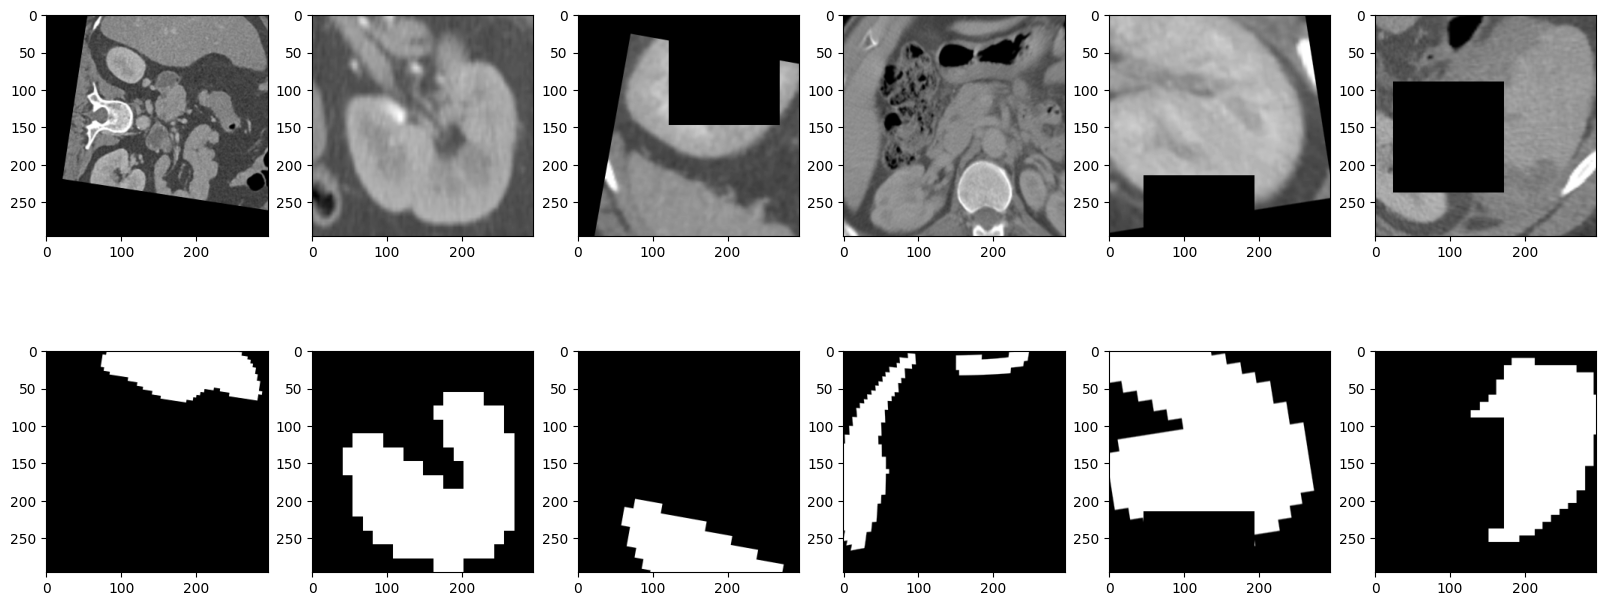

In [8]:
f, axarr = plt.subplots(2,6)
for p in range(6):
    idx = p * 20
    imgs, lbl,_ = dataset_show[idx]
    sel=7
    axarr[0, p].imshow(255*imgs[sel][1],cmap="gray")
    axarr[1, p].imshow(imgs[sel][-1],cmap="gray")

# Model

In [9]:
class TimmModel(nn.Module):
    def __init__(self, backbone, pretrained=False):
        super(TimmModel, self).__init__()

        self.encoder = timm.create_model(
            backbone,
            in_chans=in_chans,
            num_classes=out_dim,
            features_only=False,
            drop_rate=drop_rate,
            drop_path_rate=drop_path_rate,
            pretrained=pretrained
        )

        if 'efficient' in backbone:
            hdim = self.encoder.conv_head.out_channels
            self.encoder.classifier = nn.Identity()
        elif 'convnext' in backbone:
            hdim = self.encoder.head.fc.in_features
            self.encoder.head.fc = nn.Identity()


        #self.lstm = nn.LSTM(hdim, 64, num_layers=1, dropout=drop_rate, bidirectional=True, batch_first=True)
        self.head = nn.Sequential(nn.Dropout(drop_rate_last),nn.Linear(hdim, out_dim))
        #self.head = nn.Sequential(
        #    nn.Linear(128, 64),
        #    nn.BatchNorm1d(64),
        #    nn.Dropout(drop_rate_last),
        #    nn.LeakyReLU(0.1),
        #    nn.Linear(64, out_dim),
        #)
        print("enocder feauters dim",hdim)

    def forward(self, x):  # (bs, nslice, ch, sz, sz)
        bs = x.shape[0]
        x = x.view(bs * n_slice_per_c, in_chans, image_size, image_size)
        feat = self.encoder(x)
        #feat = feat.view(bs, n_slice_per_c, -1)
        #feat, _ = self.lstm(feat)
        #feat = feat.contiguous().view(bs * n_slice_per_c, -1)
        feat = self.head(feat)
        feat = feat.view(bs, n_slice_per_c,out_dim).contiguous()

        return feat

In [10]:
m = TimmModel(backbone)
m(torch.rand(2, n_slice_per_c, in_chans, image_size, image_size)).shape

enocder feauters dim 1408


torch.Size([2, 24, 3])

In [11]:
from torchinfo import summary
summary(m,(1,n_slice_per_c,in_chans,image_size,image_size))

Layer (type:depth-idx)                             Output Shape              Param #
TimmModel                                          [1, 24, 3]                --
├─EfficientNet: 1-1                                [24, 1408]                --
│    └─Conv2dSame: 2-1                             [24, 32, 148, 148]        1,152
│    └─BatchNormAct2d: 2-2                         [24, 32, 148, 148]        64
│    │    └─Identity: 3-1                          [24, 32, 148, 148]        --
│    │    └─SiLU: 3-2                              [24, 32, 148, 148]        --
│    └─Sequential: 2-3                             [24, 208, 10, 10]         --
│    │    └─Sequential: 3-3                        [24, 16, 148, 148]        6,976
│    │    └─Sequential: 3-4                        [24, 32, 74, 74]          94,016
│    │    └─Sequential: 3-5                        [24, 56, 37, 37]          296,400
│    │    └─Sequential: 3-6                        [24, 104, 19, 19]         388,124
│    │    └─Seq

In [12]:
ce = nn.CrossEntropyLoss(reduction='none', label_smoothing=0.0)

mapping = torch.tensor([1., 2., 4.]).cuda()
mapping=mapping/torch.mean(mapping)

def criterion(logits, targets,counts=None,weights=None):
    b=logits.shape[0]
    logits=logits.view(-1,out_dim)
    targets=targets.view(-1,out_dim)
    loss = ce(logits, targets)
    ll=torch.argmax(targets,dim=1) 
    #print("logits",logits[0:5,:],"targets",ll[0:5])

    #0->1,1->2,2->4 

# Use torch.index_select to apply the mapping
    #w = torch.index_select(mapping, dim=0, index=ll)
    if weights is not None:
        w=torch.matmul(targets,mapping)
    else:
        w=torch.ones(b).float().cuda()
    if counts is not None:
        counts=counts.view(-1)
        w=w/counts
    loss=loss.reshape((b,-1))
    w=w.reshape((b,-1))
    loss=torch.mean(loss,dim=1)

    w=torch.mean(w,dim=1)
    return loss,w

In [13]:
from torch.distributions.beta import Beta
beta=Beta(torch.tensor([0.2]),torch.tensor([0.2]))

def mix_up(images1,labels1):
    # Unpack two datasets
    batch_size = images1.shape[0]
    # Sample lambda and reshape it to do the mixup
    l = beta.sample(torch.Size([batch_size])).cuda()
    x_l = l.reshape((batch_size, 1, 1, 1,1))
    y_l = l.reshape((batch_size, 1,1))
    idx = torch.randperm(batch_size).cuda()
    images2=images1[idx,...]
    labels2=labels1[idx,...]
    # Perform mixup on both images and labels by combining a pair of images/labels
    # (one from each dataset) into one image/label
    images = images1 * x_l + images2 * (1 - x_l)
    labels = labels1 * y_l + labels2 * (1 - y_l)
    return (images, labels)


def train_func(model, loader_train, optimizer, scaler=None):
    model.train()
    train_loss = []
    ws=[]
    bar = tqdm(loader_train)
    for images, targets,_ in bar:
        optimizer.zero_grad()
        images = images.cuda()
        targets = targets.cuda()
  
        if random.random() < p_mixup:
            images, targets = mix_up(images, targets)

        if use_amp:
            with amp.autocast():
                logits = model(images)
                loss,w = criterion(logits, targets)
                loss1=torch.mean(loss*w)
            scaler.scale(loss1).backward()
            scaler.step(optimizer)
            scaler.update()
            train_loss.extend(loss.detach().cpu())

        else:
            logits = model(images)
            loss,w = criterion(logits, targets)
            loss1=torch.mean(loss*w)
            loss1.backward()
            optimizer.step()
            train_loss.extend(loss.detach().cpu())

            
        ws.extend(w.detach().cpu())
        bar.set_description(f'smth:{np.average(train_loss[-100:],weights=ws[-100:]):.4f}')

    return np.average(train_loss,weights=ws)


def valid_func(model, loader_valid,dff):
    model.eval()
    valid_loss=[]
    valid_loss_progress = []
    outputs = []
    tgs=[]
    ws=[]
    ws_progress=[]
    bar = tqdm(loader_valid)
    with torch.no_grad():
        for images, targets,counts in bar:
            images = images.cuda()
            targets = targets.cuda()
            counts=counts.cuda()

            #if use_amp:
            #    with amp.autocast():
            
            logits = model(images)
            blogits=torch.mean(logits,dim=1) # average logits across slices
            loss,w=criterion(logits,targets,counts,mapping)

            ws_progress.extend(w.cpu())
            valid_loss_progress.extend(loss.cpu())
            out=torch.unbind(blogits,dim=0)   
            outputs.extend(out)
            tt=targets[:,0,:] # first slice
            tgs.extend(torch.unbind(tt,dim=0))
            bar.set_description(f'smth:{np.average(valid_loss_progress[-100:],weights=ws_progress[-100:]):.4f}')
        for pid in dff["patient_id"].unique():
            for c in range(3):
                #print("patient",pid,"organ",c)
                inds=dff[(dff["patient_id"]==pid) & (dff["c"]==c)].index.values
                #print(pid,c,inds[0],dff.iloc[inds[0]])
                la=torch.mean(torch.stack([outputs[i] for i in inds]),dim=0) # average logits across up to two series per patient
                ta=tgs[inds[0]]

                loss = ce(la[None,:], ta[None,:])
                #print("fpatient id {pid}, organ {c}, {la} , {ta}, {loss}")
                valid_loss.append(loss.item())
                ta=torch.argmax(ta)
                w=mapping[ta].item()
                #print(ta.item(),dff.iloc[inds[0]]["label1"])
                assert ta.item()==dff.iloc[inds[0]]["label1"]
                ws.append(w)
        
        valid_loss=np.average(valid_loss,weights=ws)  
                
    return valid_loss


/home/sronen/code/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/home/sronen/code/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate yo

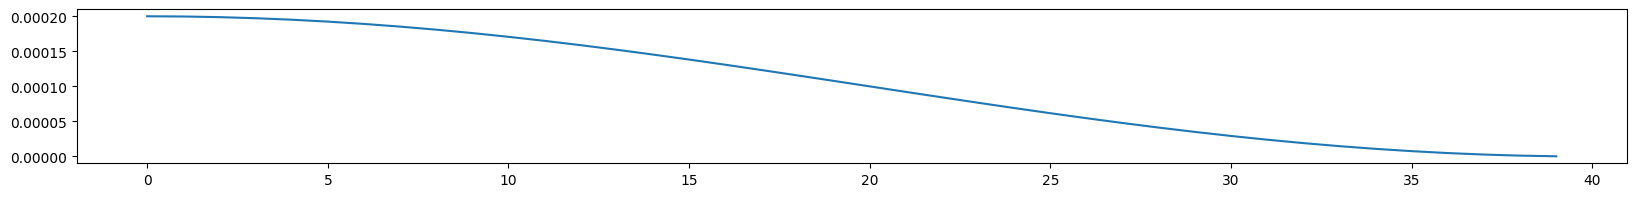

In [14]:
rcParams['figure.figsize'] = 20, 2
optimizer = optim.AdamW(m.parameters(), lr=init_lr)
scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs, eta_min=eta_min)

lrs = []
for epoch in range(1, n_epochs+1):
    scheduler_cosine.step(epoch-1)
    lrs.append(optimizer.param_groups[0]["lr"])
plt.plot(range(len(lrs)), lrs)



In [15]:
del m,optimizer
torch.cuda.empty_cache()
gc.collect()

0

# Training

In [16]:
from torch.utils.data import WeightedRandomSampler
def run(fold):

    log_file = os.path.join(log_dir, f'{kernel_type}.txt')
    model_file = os.path.join(model_dir, f'{kernel_type}_fold{fold}_best.pth')

    train_ = df[df['fold'] != fold].reset_index(drop=True)
    valid_ = df[df['fold'] == fold].reset_index(drop=True)
    dataset_train = CLSDataset(train_, 'train', transform=transforms_train)
    dataset_valid = CLSDataset(valid_, 'valid', transform=transforms_valid)
    

    class_counts = train_.label1.value_counts()
    print("class_counts",class_counts)
    #class_w=[1/c for c in class_counts]
    class_w=[1,2,4]
    sample_train_weights=[class_w[i] for i in train_.label1.values]
    sample_train_weights=[sample_train_weights[i]/train_.counts.values[i] for i in range(len(train_))]


    nsamp=3000
    sampler=WeightedRandomSampler(weights=sample_train_weights,num_samples=nsamp)

    
    #loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
    loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, num_workers=num_workers, drop_last=True,sampler=sampler)

    loader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    model = TimmModel(backbone, pretrained=True)
    model = model.to(device)

    optimizer = optim.AdamW(model.parameters(), lr=init_lr,weight_decay=1e-4)
    scaler = torch.cuda.amp.GradScaler() if use_amp else None

    metric_best = np.inf

    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, n_epochs, eta_min=eta_min)

    print(len(dataset_train), len(dataset_valid))

    for epoch in range(1, n_epochs+1):
        print(time.ctime(), 'Epoch:', epoch)
        train_loss = train_func(model, loader_train, optimizer, scaler)
        scheduler_cosine.step(epoch-1)   
        valid_loss = valid_func(model, loader_valid,valid_)
    
        metric = valid_loss

        content = time.ctime() + ' ' + f'Fold {fold}, Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, train loss: {train_loss:.5f}, valid loss: {valid_loss:.5f}, metric: {(metric):.6f}.'
        print(content)
        with open(log_file, 'a') as appender:
            appender.write(content + '\n')

        if metric < metric_best:
            print(f'metric_best ({metric_best:.6f} --> {metric:.6f}). Saving model ...')
#             if not DEBUG:
            torch.save(model.state_dict(), model_file)
            metric_best = metric

        # Save Last
        if not DEBUG:
            torch.save(
                {
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scaler_state_dict': scaler.state_dict() if scaler else None,
                    'score_best': metric_best,
                },
                model_file.replace('_best', '_last')
            )

    del model
    torch.cuda.empty_cache()
    gc.collect()

In [17]:
TRAINING=True
if TRAINING:
    run(0)
    run(1)
    run(2)
    run(3)
    run(4)

class_counts label1
0    10258
1      689
2      336
Name: count, dtype: int64
enocder feauters dim 1408
11283 2850
Thu Sep 14 16:39:44 2023 Epoch: 1


smth:0.3621: 100%|██████████| 950/950 [02:13<00:00,  7.14it/s]


Thu Sep 14 16:46:01 2023 Fold 0, Epoch 1, lr: 0.0002000, train loss: 0.64114, valid loss: 0.61466, metric: 0.614657.
metric_best (inf --> 0.614657). Saving model ...
Thu Sep 14 16:46:01 2023 Epoch: 2


smth:0.3893: 100%|██████████| 950/950 [02:12<00:00,  7.18it/s]


Thu Sep 14 16:52:01 2023 Fold 0, Epoch 2, lr: 0.0001997, train loss: 0.63279, valid loss: 0.60910, metric: 0.609095.
metric_best (0.614657 --> 0.609095). Saving model ...
Thu Sep 14 16:52:02 2023 Epoch: 3


smth:0.4196: 100%|██████████| 950/950 [02:15<00:00,  7.00it/s]


Thu Sep 14 16:58:20 2023 Fold 0, Epoch 3, lr: 0.0001988, train loss: 0.57345, valid loss: 0.58918, metric: 0.589178.
metric_best (0.609095 --> 0.589178). Saving model ...
Thu Sep 14 16:58:20 2023 Epoch: 4


smth:0.4278: 100%|██████████| 950/950 [02:15<00:00,  6.99it/s]


Thu Sep 14 17:04:38 2023 Fold 0, Epoch 4, lr: 0.0001972, train loss: 0.59838, valid loss: 0.58116, metric: 0.581158.
metric_best (0.589178 --> 0.581158). Saving model ...
Thu Sep 14 17:04:38 2023 Epoch: 5


smth:0.3972: 100%|██████████| 950/950 [02:12<00:00,  7.18it/s]


Thu Sep 14 17:10:53 2023 Fold 0, Epoch 5, lr: 0.0001951, train loss: 0.56271, valid loss: 0.56913, metric: 0.569134.
metric_best (0.581158 --> 0.569134). Saving model ...
Thu Sep 14 17:10:54 2023 Epoch: 6


smth:0.3633: 100%|██████████| 950/950 [02:18<00:00,  6.88it/s]


Thu Sep 14 17:17:01 2023 Fold 0, Epoch 6, lr: 0.0001924, train loss: 0.57014, valid loss: 0.55709, metric: 0.557092.
metric_best (0.569134 --> 0.557092). Saving model ...
Thu Sep 14 17:17:01 2023 Epoch: 7


smth:0.3591: 100%|██████████| 950/950 [02:17<00:00,  6.90it/s]


Thu Sep 14 17:23:16 2023 Fold 0, Epoch 7, lr: 0.0001891, train loss: 0.52931, valid loss: 0.55951, metric: 0.559506.
Thu Sep 14 17:23:17 2023 Epoch: 8


smth:0.3551: 100%|██████████| 950/950 [02:15<00:00,  6.99it/s]


Thu Sep 14 17:29:33 2023 Fold 0, Epoch 8, lr: 0.0001853, train loss: 0.56622, valid loss: 0.61236, metric: 0.612355.
Thu Sep 14 17:29:33 2023 Epoch: 9


smth:0.3819: 100%|██████████| 950/950 [02:12<00:00,  7.15it/s]


Thu Sep 14 17:35:41 2023 Fold 0, Epoch 9, lr: 0.0001809, train loss: 0.50783, valid loss: 0.51695, metric: 0.516951.
metric_best (0.557092 --> 0.516951). Saving model ...
Thu Sep 14 17:35:41 2023 Epoch: 10


smth:0.3351: 100%|██████████| 950/950 [02:11<00:00,  7.25it/s]


Thu Sep 14 17:41:46 2023 Fold 0, Epoch 10, lr: 0.0001760, train loss: 0.53310, valid loss: 0.61807, metric: 0.618067.
Thu Sep 14 17:41:46 2023 Epoch: 11


smth:0.3014: 100%|██████████| 950/950 [02:18<00:00,  6.85it/s]


Thu Sep 14 17:47:59 2023 Fold 0, Epoch 11, lr: 0.0001707, train loss: 0.50818, valid loss: 0.63756, metric: 0.637555.
Thu Sep 14 17:47:59 2023 Epoch: 12


smth:0.3218: 100%|██████████| 950/950 [02:17<00:00,  6.90it/s]


Thu Sep 14 17:54:19 2023 Fold 0, Epoch 12, lr: 0.0001649, train loss: 0.50095, valid loss: 0.59981, metric: 0.599813.
Thu Sep 14 17:54:19 2023 Epoch: 13


smth:0.6469:  12%|█▏        | 111/950 [00:18<02:19,  6.01it/s]


KeyboardInterrupt: 